In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
data_path = 'src/data/recipe_dataset.csv'  # Update path if necessary
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
data.head()


,Unnamed: 0,title,ingredients,directions,link,source,NER,calories_estimated
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",1662.0
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",1235.0
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",1950.0
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",986.0
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",1586.0


In [2]:
import re

def extract_time(text):
    # Define regex patterns for minutes and hours
    time_patterns = [
        r"(\d+)\s*(minutes|min)",       # Matches "20 minutes" or "20 min"
        r"(\d+)\s*(heures|hours|hrs|h)" # Matches "1 heure", "2 hours", etc.
    ]
    
    total_minutes = 0
    
    # Iterate over each regex pattern
    for pattern in time_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        
        # Convert matches to total time in minutes
        for match in matches:
            value = int(match[0])  # Numeric part
            unit = match[1].lower()
            
            if "heure" in unit or "hour" in unit:  # Convert hours to minutes
                total_minutes += value * 60
            else:
                total_minutes += value  # Minutes remain as is

    return total_minutes


In [3]:
# Parse directions if still in JSON-like format
import ast

if isinstance(data['directions'].iloc[0], str):  # Check if parsing is needed
    data['directions_parsed'] = data['directions'].apply(lambda x: ast.literal_eval(x))
else:
    data['directions_parsed'] = data['directions']

# Extract cooking time
data['cooking_time'] = data['directions_parsed'].apply(
    lambda directions: sum(extract_time(step) for step in directions) if isinstance(directions, list) else 0
)

print(data[['directions', 'cooking_time']].head(5))


                                          directions  cooking_time
0  ["In a heavy 2-quart saucepan, mix brown sugar...            35
1  ["Place chipped beef on bottom of baking dish....           180
2  ["In a slow cooker, combine all ingredients. C...           240
3  ["Boil and debone chicken.", "Put bite size pi...            20
4  ["Combine first four ingredients and press in ...            20


In [4]:
# Parse JSON-like columns (ingredients, directions, NER)
import ast

data['ingredients_parsed'] = data['ingredients'].apply(lambda x: ast.literal_eval(x))
data['directions_parsed'] = data['directions'].apply(lambda x: ast.literal_eval(x))
data['NER_parsed'] = data['NER'].apply(lambda x: ast.literal_eval(x))

# Example: Count number of ingredients and steps as numeric features
data['num_ingredients'] = data['ingredients_parsed'].apply(len)
data['num_steps'] = data['directions_parsed'].apply(len)



# Select relevant features for clustering
data_processed = data[['num_ingredients', 'num_steps', 'cooking_time']]

data_processed.head()


,num_ingredients,num_steps,cooking_time
0,6,6,35
1,4,3,180
2,6,1,240
3,5,6,20
4,5,3,20


In [5]:
# Normalize features using Min-Max Scaling
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_processed)

# Convert back to a DataFrame
data_normalized = pd.DataFrame(data_normalized, columns=data_processed.columns)
data_normalized.head()


,num_ingredients,num_steps,cooking_time
0,0.014837,0.084746,0.005476
1,0.008902,0.033898,0.028165
2,0.014837,0.000000,0.037553
3,0.011869,0.084746,0.003129
4,0.011869,0.033898,0.003129


Silhouette Score for K-Means: 0.47580957833097176


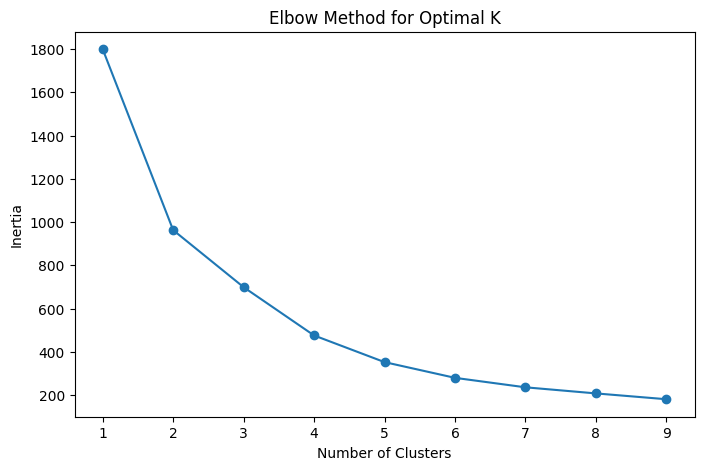

In [15]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_normalized)

# Add clusters to the DataFrame
data_normalized['Cluster'] = clusters

# Evaluate clusters using Silhouette Score
silhouette_avg = silhouette_score(data_normalized.iloc[:, :-1], clusters)
print(f"Silhouette Score for K-Means: {silhouette_avg}")

# Elbow Method Visualization
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized.iloc[:, :-1])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [ ]:
numerical_data = data_normalized.select_dtypes(include=['number'])


In [36]:
# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(numerical_data)

# Add clusters to the DataFrame
numerical_data['Cluster'] = clusters

# Evaluate clusters using Silhouette Score
silhouette_avg = silhouette_score(data_normalized.iloc[:, :-1], clusters)
print(f"Silhouette Score for K-Means: {silhouette_avg}")

Silhouette Score for K-Means: 0.9496508870863387


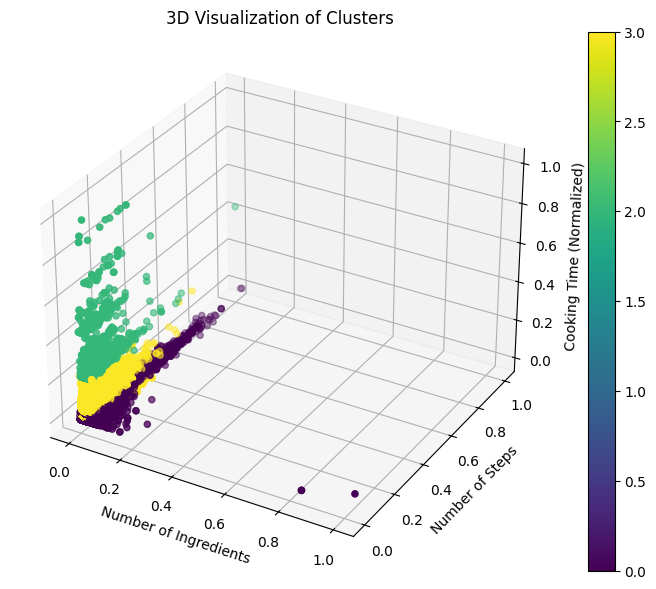

In [38]:
# 3D Visualization of K-Means Clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_normalized['num_ingredients'],
                     data_normalized['num_steps'],
                     data_normalized['cooking_time'],
                     c=numerical_data['Cluster'], cmap='viridis')
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Number of Ingredients')
ax.set_ylabel('Number of Steps')
ax.set_zlabel('Cooking Time (Normalized)')
plt.colorbar(scatter)
plt.show()


In [17]:
# Classification Example: Map clusters to labels
data['Complexity'] = data_normalized['Cluster'].map({0: 'Simple', 1: 'Moderate', 2: 'Complex'})
print(data[['title', 'Complexity']].head())

# Optionally, implement regression to predict a complexity score here.


                   title Complexity
0    No-Bake Nut Cookies    Complex
1  Jewell Ball'S Chicken     Simple
2            Creamy Corn     Simple
3          Chicken Funny    Complex
4   Reeses Cups(Candy)       Simple


In [ ]:
from sklearn.mixture import GaussianMixture
import pandas as pd

# Step 1: Ensure `data_normalized` contains only numerical values
# Drop or exclude any non-numerical columns if present
numerical_data = data_normalized.select_dtypes(include=['number'])

# Step 2: Fit GMM
gmm = GaussianMixture(n_components=3, random_state=42)  # Adjust the number of components
gmm_clusters = gmm.fit_predict(numerical_data)




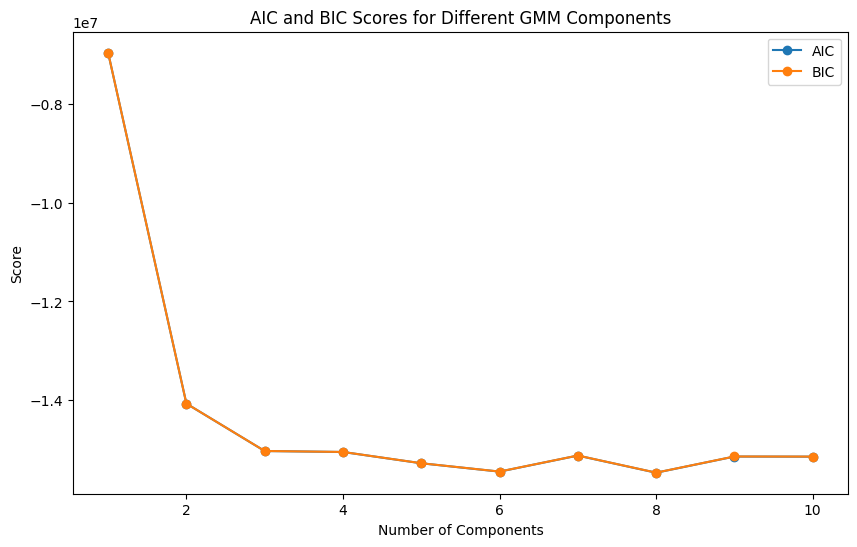

Optimal number of components based on AIC: 8
Optimal number of components based on BIC: 8


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Define a range of n_components to test
components_range = range(1, 11)  # For example, try between 1 and 10 components

# Initialize lists to store AIC and BIC values
aic_values = []
bic_values = []

# Fit a GMM for each n_components and compute AIC and BIC
for n in components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(numerical_data)
    aic_values.append(gmm.aic(numerical_data))
    bic_values.append(gmm.bic(numerical_data))

# Plot AIC and BIC scores
plt.figure(figsize=(10, 6))
plt.plot(components_range, aic_values, label='AIC', marker='o')
plt.plot(components_range, bic_values, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for Different GMM Components')
plt.legend()
plt.show()

# Print the optimal number of components based on AIC and BIC
optimal_components_aic = components_range[np.argmin(aic_values)]
optimal_components_bic = components_range[np.argmin(bic_values)]

print(f"Optimal number of components based on AIC: {optimal_components_aic}")
print(f"Optimal number of components based on BIC: {optimal_components_bic}")


In [28]:
from sklearn.mixture import GaussianMixture
import pandas as pd

# Step 1: Ensure `data_normalized` contains only numerical values
# Drop or exclude any non-numerical columns if present
numerical_data = data_normalized.select_dtypes(include=['number'])

# Step 2: Fit GMM
gmm = GaussianMixture(n_components=4, random_state=42)  # Adjust the number of components
gmm_clusters = gmm.fit_predict(numerical_data)

# Step 3: Add cluster labels to the original DataFrame
data_normalized['GMM_Cluster'] = gmm_clusters

# Step 4: Map GMM cluster labels to descriptive names
cluster_mapping = {
    0: 'Simple',
    1: 'Moderate',
    2: 'Hard',
    3: 'Very Hard'
    
}
data_normalized['Cluster_Name'] = data_normalized['GMM_Cluster'].map(cluster_mapping)

# Step 5: View the first few rows with cluster names
print(data_normalized[['GMM_Cluster', 'Cluster_Name']].head())


   GMM_Cluster Cluster_Name
0            2         Hard
1            1     Moderate
2            1     Moderate
3            2         Hard
4            0       Simple


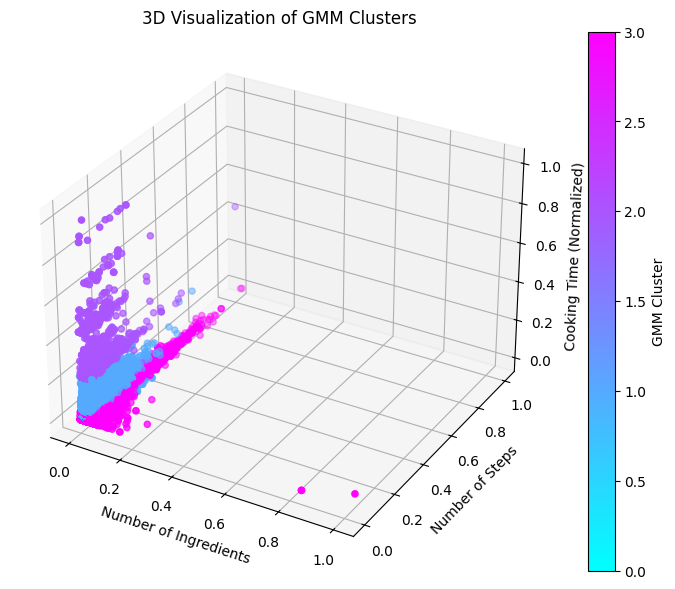

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Ensure you import this for 3D plotting

# 3D Visualization of GMM Clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for GMM clusters
scatter = ax.scatter(
    data_normalized['num_ingredients'], 
    data_normalized['num_steps'],      
    data_normalized['cooking_time'],   
    c=data_normalized['GMM_Cluster'],   # Use the GMM cluster labels
    cmap='cool'  # Use a different colormap if desired
)

# Add titles and labels
ax.set_title('3D Visualization of GMM Clusters')
ax.set_xlabel('Number of Ingredients')
ax.set_ylabel('Number of Steps')
ax.set_zlabel('Cooking Time (Normalized)')

# Add a color bar to show cluster assignments
plt.colorbar(scatter, ax=ax, label='GMM Cluster')

# Show the plot
plt.show()


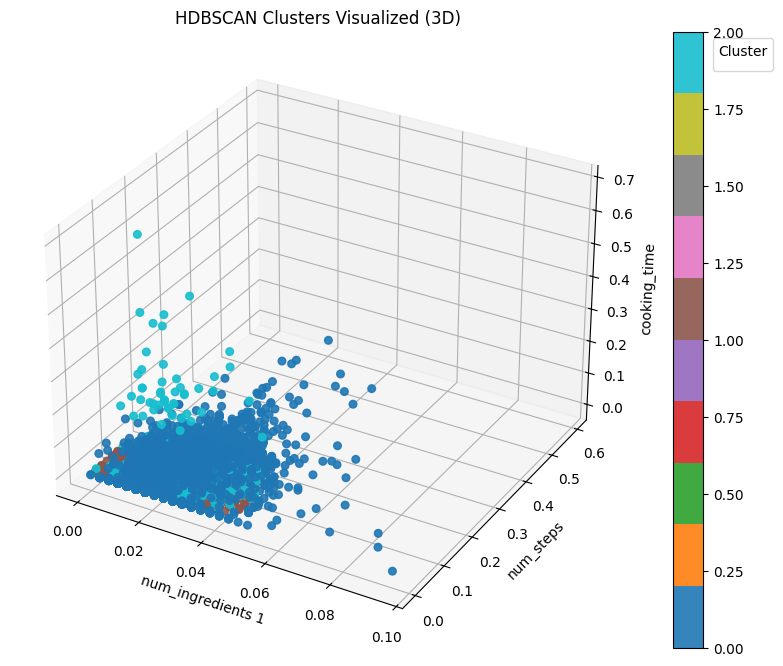

1    220090
2    170342
0    114067
Name: Cluster, dtype: int64


In [ ]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming `data_normalized` is your preprocessed DataFrame (normalized/scaled)

# Step 1: Run HDBSCAN directly on the normalized data (no PCA)
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100000, gen_min_span_tree=True)
cluster_labels = hdbscan_clusterer.fit_predict(numerical_data)

# Step 2: Add clusters back to the dataset
data_with_clusters = numerical_data.copy()
data_with_clusters['Cluster'] = cluster_labels

# Step 3: Sample data for visualization (to avoid overcrowding)
plot_sample = data_with_clusters.sample(n=10000, random_state=42)

# Step 4: Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Select the first three columns for 3D visualization, if they exist
x = plot_sample.iloc[:, 0]
y = plot_sample.iloc[:, 1]
z = plot_sample.iloc[:, 2]

# Scatter plot
scatter = ax.scatter(x, y, z, c=plot_sample['Cluster'], cmap='tab10', s=30, alpha=0.9)

# Set axis labels
ax.set_title("HDBSCAN Clusters Visualized (3D)")
ax.set_xlabel("num_ingredients 1")
ax.set_ylabel("num_steps")
ax.set_zlabel("cooking_time")

# Add a colorbar for the clusters
plt.colorbar(scatter)

# Modify the legend to show only unique clusters
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = sorted(set(cluster_labels))  # Sort cluster labels for clarity
new_labels = [f"Cluster {label}" if label >= 0 else "Noise" for label in unique_labels]
plt.legend(handles[:len(unique_labels)], new_labels, title="Cluster", loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

# Step 5: Print cluster sizes
cluster_counts = data_with_clusters['Cluster'].value_counts()
print(cluster_counts)


In [ ]:

#Higher Calinski-Harabasz Score indicates better-defined clusters.
from sklearn.metrics import calinski_harabasz_score

# Compute Calinski-Harabasz scores
calinski_harabasz_scores = {
    "K-Means": calinski_harabasz_score(data_normalized.iloc[:, :-1], clusters),
    "GMM": calinski_harabasz_score(data_normalized.iloc[:, :-1], gmm_clusters),
    #"HDBSCAN": calinski_harabasz_score(data_normalized.iloc[:, :-1], cluster_labels)
}
print("Calinski-Harabasz Scores:")
print(calinski_harabasz_scores)
#It is sensitive to the size of the dataset; larger datasets or datasets with many clusters often have much higher scores.

Calinski-Harabasz Scores:
{'K-Means': 76814887.58910963, 'GMM': 76814887.58910963, 'HDBSCAN': 1261137.1463229856}


In [ ]:
#Lower Davies-Bouldin Index indicates better separation.
#lower intra-cluster distances and higher inter-cluster separation)
from sklearn.metrics import davies_bouldin_score

# Compute Davies-Bouldin scores
davies_bouldin_scores = {
    "K-Means": davies_bouldin_score(data_normalized.iloc[:, :-1], clusters),
    "GMM": davies_bouldin_score(data_normalized.iloc[:, :-1], gmm_clusters),
    
    #"HDBSCAN": davies_bouldin_score(data_normalized.iloc[:, :-1], cluster_labels)
}
print("Davies-Bouldin Scores:")
print(davies_bouldin_scores)


Davies-Bouldin Scores:
{'K-Means': 0.05930383330656582, 'GMM': 0.05562174465152751, 'HDBSCAN': 16.26639820772795}


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import silhouette_score
import dagshub
import pickle
mlflow.set_tracking_uri("https://dagshub.com/nada142/mlops_project.mlflow")

dagshub.init(repo_owner='nada142', repo_name='mlops_project', mlflow=True)

# Set up MLflow experiment
mlflow.set_experiment("Clustering Models")

# Function to save model as a pickle file
def save_model_pickle(model, file_name):
    with open(file_name, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved locally as {file_name}")

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def log_clustering_model(model, model_name, data, labels=None):
    with mlflow.start_run(run_name=model_name):
        # Save model locally as pickle
        pickle_file = f"{model_name}_model.pkl"
        save_model_pickle(model, pickle_file)
        
        # Log model to MLflow
        mlflow.sklearn.log_model(model, "model")
        
        # Log parameters (if any)
        if hasattr(model, 'get_params'):
            mlflow.log_params(model.get_params())
        
        # Log metrics
        if labels is not None:
            # Silhouette Score
            silhouette = silhouette_score(data, labels)
            mlflow.log_metric("silhouette_score", silhouette)
            
            # Calinski-Harabasz Score
            calinski_harabasz = calinski_harabasz_score(data, labels)
            mlflow.log_metric("calinski_harabasz_score", calinski_harabasz)
            
            # Davies-Bouldin Score
            davies_bouldin = davies_bouldin_score(data, labels)
            mlflow.log_metric("davies_bouldin_score", davies_bouldin)
        
        # Additional metrics for KMeans
        if model_name == "KMeans":
            inertia = model.inertia_  # Total within-cluster sum of squares
            mlflow.log_metric("inertia", inertia)
        
        # Additional metrics for GMM
        if model_name == "GMM":
            aic = model.aic(data)  # Akaike Information Criterion
            bic = model.bic(data)  # Bayesian Information Criterion
            mlflow.log_metric("aic", aic)
            mlflow.log_metric("bic", bic)
        
        # Additional metrics for HDBSCAN
        if model_name == "HDBSCAN":
            cluster_persistence = model.cluster_persistence_
            mlflow.log_metric("cluster_persistence_mean", cluster_persistence.mean())
            mlflow.log_metric("cluster_persistence_std", cluster_persistence.std())
        
        print(f"Logged {model_name} to MLflow with metrics and saved locally")

# Example usage for each model
# KMeans
log_clustering_model(kmeans, "KMeans", numerical_data, labels=kmeans.labels_)

# Gaussian Mixture Model (GMM)
log_clustering_model(gmm, "GMM", numerical_data, labels=gmm.predict(numerical_data))

# HDBSCAN
#log_clustering_model(hdbscan_clusterer, "HDBSCAN", numerical_data, labels=hdbscan_clusterer.labels_)
